In [123]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(50)
cfg.set_tbl_cols(100)

polars.config.Config

In [122]:
PERCENTILES = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]

In [2]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/building_blocks.json', 'r') as f:
    bbs_meta = json.load(f)

[print(k, '-->', len(v)) for k, v in bbs_meta.items()]

train_bbs --> 1145
train_bb1s --> 271
train_bb2s --> 693
train_bb3s --> 872
test_bb1s --> 341
test_bb2s --> 1140
test_bb3s --> 1389
test_bbs --> 2110
all_bbs --> 2110


[None, None, None, None, None, None, None, None, None]

In [3]:
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv')\
    .select(
        pl.col('molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('BRD4', 'HSA', 'eSH').cast(pl.UInt8),
    )\
    .collect()
print(train_df.estimated_size('mb'))
train_df

7851.068469047546


molecule,bb1,bb2,bb3,BRD4,HSA,eSH
str,u16,u16,u16,u8,u8,u8
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0
…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0


In [4]:
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v2.csv')\
    .select(
        pl.col('id','molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('protein'),
    ).collect()
print(test_df.estimated_size('mb'))
test_df

147.45777130126953


id,molecule,bb1,bb2,bb3,protein
i64,str,u16,u16,u16,str
295246830,"""C#CCCC[C@H](Nc…",1989,409,409,"""BRD4"""
295246831,"""C#CCCC[C@H](Nc…",1989,409,409,"""HSA"""
295246832,"""C#CCCC[C@H](Nc…",1989,409,409,"""sEH"""
295246833,"""C#CCCC[C@H](Nc…",1989,409,1012,"""BRD4"""
295246834,"""C#CCCC[C@H](Nc…",1989,409,1012,"""HSA"""
…,…,…,…,…,…
296921721,"""COC1CCC(CCNc2n…",141,1415,1556,"""HSA"""
296921722,"""COC1CCC(CCNc2n…",141,1415,1556,"""sEH"""
296921723,"""[N-]=[N+]=NCCC…",141,1415,236,"""BRD4"""


In [5]:
train_df[:10, 'molecule'].to_list()

['C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)C)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCC(C)OCC=C)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCCCOCC=C)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCCOCC=C)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(Nc3cnn(C4CCN(C(=O)OC(C)(C)C)CC4)c3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(Nc3n[nH]c4c3CN(C(=O)OC(C)(C)C)C4(C)C)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1']

In [7]:
from deepchem.splits.splitters import _generate_scaffold

for i in range(10000):
    scaffold = _generate_scaffold(train_df[i, 'molecule'])
    scaffold2 = _generate_scaffold(train_df[i, 'molecule'].replace('[Dy]', ''))
    assert scaffold == scaffold2
    # print(i, train_df[i, 'molecule'], '-->', scaffold)

In [8]:
train_scaffolds = Parallel(n_jobs=48, backend='loky')(
    delayed(_generate_scaffold)(smile, False) for smile in tqdm(train_df['molecule']))
print(len(train_scaffolds))
train_scaffolds[:5]

  0%|                               | 48/98415610 [00:21<12234:51:34,  2.23it/s]No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for SPS. Feat

98415610


['c1ccc(CNc2ncnc(NCC3CCCN3c3cccnn3)n2)cc1',
 'c1ccc(CNc2ncnc(NCc3ccccn3)n2)cc1',
 'c1ccc(CNc2ncnc(NCc3ccccc3)n2)cc1',
 'c1ccc(CNc2ncncn2)cc1',
 'c1ccc(CNc2ncncn2)cc1']

In [9]:
len(train_scaffolds)

98415610

In [10]:
len(set(train_scaffolds))

5711873

In [12]:
test_scaffolds = Parallel(n_jobs=48, backend='loky')(
    delayed(_generate_scaffold)(smile, False) for smile in tqdm(test_df['molecule']))
print(len(test_scaffolds), len(set(test_scaffolds)))
test_scaffolds[:5]

100%|██████████████████████████████| 1674896/1674896 [00:58<00:00, 28415.76it/s]


1674896 368671


['c1ccc(Nc2ncnc(Nc3ccccc3)n2)cc1',
 'c1ccc(Nc2ncnc(Nc3ccccc3)n2)cc1',
 'c1ccc(Nc2ncnc(Nc3ccccc3)n2)cc1',
 'c1ccc(Nc2ncnc(Nc3ncnc4[nH]cnc34)n2)cc1',
 'c1ccc(Nc2ncnc(Nc3ncnc4[nH]cnc34)n2)cc1']

In [41]:
878_022 / 368671

2.3815868348744544

In [42]:
98_415_610 / 5_711_873

17.230006689574505

In [14]:
all_scaffolds = list(set(train_scaffolds + test_scaffolds))
len(set(train_scaffolds)), len(set(test_scaffolds)), len(all_scaffolds)

(5711873, 368671, 5971685)

In [15]:
len(set(train_scaffolds).intersection(set(test_scaffolds)))

108859

In [25]:
len(set(test_scaffolds).difference(set(train_scaffolds)))

259812

In [16]:
200000 / (200000 + 360000)

0.35714285714285715

In [17]:
SCAFFOLD2IDX = {e: i for i, e in enumerate(all_scaffolds)}

In [26]:
SCAFFOLD2IDX[all_scaffolds[0]]

0

In [19]:
len(set(test_scaffolds).union(set(train_scaffolds)))

5971685

In [20]:
len(all_scaffolds)

5971685

In [21]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/scaffolds.json', 'w') as f:
    json.dump(all_scaffolds, f)

In [22]:
all_scaffolds[:5]

['O=c1[nH]nc(CNc2nc(NCCc3ccccc3)nc(N3Cc4ccccc4C3)n2)[nH]1',
 'O=C(c1ccccc1)N1CCC(c2ccc(-c3ccc4c(c3)OCCO4)nc2)C1',
 'O=c1nccc(Nc2nc(NCCCc3nncs3)nc(NCCC3CC3)n2)[nH]1',
 'O=C(c1ccccc1-c1ccccc1)N1CCC(c2cccc(-c3ccc4c(c3)COCC4)c2)C1',
 'O=C(c1nccnc1N1CCCCC1)N1CC=C(c2ccnc(-c3ccc4cn[nH]c4c3)c2)C1']

In [32]:
train_scaffold_df = pl.DataFrame(
    {
        'scaffold_idx': [SCAFFOLD2IDX[scaffold] for scaffold in train_scaffolds],
        'scaffold': train_scaffolds,
    },
    schema_overrides={
        'scaffold_idx': pl.UInt32
    }
)
train_scaffold_df

scaffold_idx,scaffold
u32,str
4283326,"""c1ccc(CNc2ncnc…"
4486646,"""c1ccc(CNc2ncnc…"
1015728,"""c1ccc(CNc2ncnc…"
5301385,"""c1ccc(CNc2ncnc…"
5301385,"""c1ccc(CNc2ncnc…"
…,…
4674025,"""c1ccc2c(Nc3ncn…"
5240137,"""c1ccc2c(Nc3ncn…"
5240137,"""c1ccc2c(Nc3ncn…"


In [40]:
train_scaffold_df.select('scaffold_idx').write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_scaffold.csv')
train_scaffold_df.n_unique('scaffold_idx')

5711873

In [35]:
test_scaffold_df = pl.DataFrame(
    {
        'scaffold_idx': [SCAFFOLD2IDX[scaffold] for scaffold in test_scaffolds],
        'scaffold': test_scaffolds,
    },
    schema_overrides={
        'scaffold_idx': pl.UInt32
    }
)
test_scaffold_df

scaffold_idx,scaffold
u32,str
2217250,"""c1ccc(Nc2ncnc(…"
2217250,"""c1ccc(Nc2ncnc(…"
2217250,"""c1ccc(Nc2ncnc(…"
602641,"""c1ccc(Nc2ncnc(…"
602641,"""c1ccc(Nc2ncnc(…"
…,…
3642883,"""c1ccc2c(Nc3ncn…"
3642883,"""c1ccc2c(Nc3ncn…"
2851961,"""c1csc(CNc2ncnc…"


In [39]:
test_scaffold_df.select('scaffold_idx').write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_scaffold.csv')
test_scaffold_df.n_unique('scaffold_idx')

368671

In [44]:
70 / 341, 447 / 1140, 518 / 1390, 965 / 2110

(0.20527859237536658,
 0.39210526315789473,
 0.3726618705035971,
 0.45734597156398105)

In [45]:
965 / 2110

0.45734597156398105

In [46]:
259_812 / 5_971_685

0.04350731828621235

In [48]:
508_983 / 878_022

0.5796927639626341

In [49]:
5_711_873 / 368_671

15.493144293963995

In [50]:
98_415_610 / 878_022

112.08786340205599

# How the author does the Train-Val-Test split?
- The test set is made from the combination of several different splitting strategies. That statement was only meant to describe one of the strategies: the **bb-split**. for this split we hold out certain building blocks. But the overall test set also includes molecules from a **scaffold split** and a **random split**, hence the overlap.
- 3 split strategy: Random Split + Scaffold Split + Building Block Split

- Strategy 1: **Iterative**: BB -> Scaffold -> Random or Scaffold -> BB -> Random. I guess the correct order is **BB -> Scaffold -> Random**
- Strategy 2: **Partition**: Split datasets to 3 subsets -> do split on each subset

After that, they prune the test set by a trained model to reduce the size (e.g, filter too easy samples - non binds with high confident)


## Strategy
- BB: Split by BB with test_fraction x <= 0.45 (965 / 2110).
      Train: 
- Scaffold :Split by Scaffold with test fraction y <=  ((259_812 - ) / ) 

In [53]:
len(train_scaffold_df['scaffold_idx'])

98415610

In [54]:
train_df = train_df.with_columns(
    scaffold_idx = train_scaffold_df['scaffold_idx']
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx
str,u16,u16,u16,u8,u8,u8,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385
…,…,…,…,…,…,…,…
"""[N-]=[N+]=NCCC…",141,1415,1792,0,0,0,4674025
"""[N-]=[N+]=NCCC…",141,1415,1178,0,0,0,5240137
"""[N-]=[N+]=NCCC…",141,1415,1699,0,0,0,5240137


In [55]:
test_df = test_df.with_columns(
    scaffold_idx = test_scaffold_df['scaffold_idx']
)
test_df

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
i64,str,u16,u16,u16,str,u32
295246830,"""C#CCCC[C@H](Nc…",1989,409,409,"""BRD4""",2217250
295246831,"""C#CCCC[C@H](Nc…",1989,409,409,"""HSA""",2217250
295246832,"""C#CCCC[C@H](Nc…",1989,409,409,"""sEH""",2217250
295246833,"""C#CCCC[C@H](Nc…",1989,409,1012,"""BRD4""",602641
295246834,"""C#CCCC[C@H](Nc…",1989,409,1012,"""HSA""",602641
…,…,…,…,…,…,…
296921721,"""COC1CCC(CCNc2n…",141,1415,1556,"""HSA""",3642883
296921722,"""COC1CCC(CCNc2n…",141,1415,1556,"""sEH""",3642883
296921723,"""[N-]=[N+]=NCCC…",141,1415,236,"""BRD4""",2851961


In [60]:
test_only_bbs = list(set(bbs_meta['test_bbs']).difference(bbs_meta['train_bbs']))
BB2IDX = {e: i for i, e in enumerate(bbs_meta['all_bbs'])}
test_only_bb_idxs = [BB2IDX[e] for e in test_only_bbs]

print(test_only_bbs[:5], test_only_bb_idxs[:5])
len(test_only_bbs), len(test_only_bb_idxs)

['CC1(C)OB(c2sccc2C#N)OC1(C)C', 'CCCOc1ncc(C(F)(F)F)cc1B(O)O', 'O=C(O)c1ccc(-c2cn[nH]c2)cn1', 'NCc1ccncc1', 'CN1CCOCc2cc(B3OC(C)(C)C(C)(C)O3)ccc21'] [910, 1214, 1733, 231, 213]


(965, 965)

In [66]:
test_only_bbs_test_df = test_df.filter(pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs))
display(test_only_bbs_test_df.select(pl.col('*').n_unique()))
test_only_bbs_test_df

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
567779,508983,70,447,518,3,245841


id,molecule,bb1,bb2,bb3,protein,scaffold_idx
i64,str,u16,u16,u16,str,u32
295246830,"""C#CCCC[C@H](Nc…",1989,409,409,"""BRD4""",2217250
295246831,"""C#CCCC[C@H](Nc…",1989,409,409,"""HSA""",2217250
295246832,"""C#CCCC[C@H](Nc…",1989,409,409,"""sEH""",2217250
295246833,"""C#CCCC[C@H](Nc…",1989,409,1012,"""BRD4""",602641
295246834,"""C#CCCC[C@H](Nc…",1989,409,1012,"""HSA""",602641
…,…,…,…,…,…,…
296917260,"""O=C(c1cccc(-n2…",852,560,1719,"""HSA""",1607919
296917261,"""O=C(c1cccc(C2(…",852,560,432,"""BRD4""",4001079
296917262,"""O=C(c1cccc(N2C…",852,560,1291,"""BRD4""",1880657


In [67]:
test_only_bbs_test_df = test_df.filter(pl.col('bb1').is_in(test_only_bb_idxs) & pl.col('bb2').is_in(test_only_bb_idxs) & pl.col('bb3').is_in(test_only_bb_idxs))
display(test_only_bbs_test_df.select(pl.col('*').n_unique()))
test_only_bbs_test_df

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
567779,508983,70,447,518,3,245841


id,molecule,bb1,bb2,bb3,protein,scaffold_idx
i64,str,u16,u16,u16,str,u32
295246830,"""C#CCCC[C@H](Nc…",1989,409,409,"""BRD4""",2217250
295246831,"""C#CCCC[C@H](Nc…",1989,409,409,"""HSA""",2217250
295246832,"""C#CCCC[C@H](Nc…",1989,409,409,"""sEH""",2217250
295246833,"""C#CCCC[C@H](Nc…",1989,409,1012,"""BRD4""",602641
295246834,"""C#CCCC[C@H](Nc…",1989,409,1012,"""HSA""",602641
…,…,…,…,…,…,…
296917260,"""O=C(c1cccc(-n2…",852,560,1719,"""HSA""",1607919
296917261,"""O=C(c1cccc(C2(…",852,560,432,"""BRD4""",4001079
296917262,"""O=C(c1cccc(N2C…",852,560,1291,"""BRD4""",1880657


In [69]:
test_only_bbs_test_df = test_df.filter(pl.col('bb2').is_in(test_only_bb_idxs))
display(test_only_bbs_test_df.select(pl.col('*').n_unique()))
test_only_bbs_test_df

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
567779,508983,70,447,518,3,245841


id,molecule,bb1,bb2,bb3,protein,scaffold_idx
i64,str,u16,u16,u16,str,u32
295246830,"""C#CCCC[C@H](Nc…",1989,409,409,"""BRD4""",2217250
295246831,"""C#CCCC[C@H](Nc…",1989,409,409,"""HSA""",2217250
295246832,"""C#CCCC[C@H](Nc…",1989,409,409,"""sEH""",2217250
295246833,"""C#CCCC[C@H](Nc…",1989,409,1012,"""BRD4""",602641
295246834,"""C#CCCC[C@H](Nc…",1989,409,1012,"""HSA""",602641
…,…,…,…,…,…,…
296917260,"""O=C(c1cccc(-n2…",852,560,1719,"""HSA""",1607919
296917261,"""O=C(c1cccc(C2(…",852,560,432,"""BRD4""",4001079
296917262,"""O=C(c1cccc(N2C…",852,560,1291,"""BRD4""",1880657


Oh, no mixes between Test only BB and Train BB

In [77]:
intersection_bbs_test_df = test_df.filter(~ (pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs) ))
display(intersection_bbs_test_df.select(pl.col('*').n_unique()))
intersection_bbs_test_df

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
1107117,369039,271,693,871,3,123824


id,molecule,bb1,bb2,bb3,protein,scaffold_idx
i64,str,u16,u16,u16,str,u32
295248819,"""C#CC[C@@H](CC(…",1640,1982,1941,"""BRD4""",2217250
295248820,"""C#CC[C@@H](CC(…",1640,1982,1941,"""HSA""",2217250
295248821,"""C#CC[C@@H](CC(…",1640,1982,1941,"""sEH""",2217250
295248822,"""C#CC[C@@H](CC(…",1640,1982,1242,"""BRD4""",1281519
295248823,"""C#CC[C@@H](CC(…",1640,1982,1242,"""HSA""",1281519
…,…,…,…,…,…,…
296921721,"""COC1CCC(CCNc2n…",141,1415,1556,"""HSA""",3642883
296921722,"""COC1CCC(CCNc2n…",141,1415,1556,"""sEH""",3642883
296921723,"""[N-]=[N+]=NCCC…",141,1415,236,"""BRD4""",2851961


In [72]:
1107117  + 567779

1674896

In [78]:
369039 + 508983 

878022

In [80]:
369039 / 878_022

0.4203072360373658

In [75]:
508983 / (70 * 447 * 518)

0.0314027697057419

In [76]:
(99_293_632 - 508983) / (271 * 693 * 872)

0.6032126639924805

In [79]:
98_415_610 / (271 * 693 * 872)

0.6009591863463016

In [81]:
intersection_bbs_test_df

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
i64,str,u16,u16,u16,str,u32
295248819,"""C#CC[C@@H](CC(…",1640,1982,1941,"""BRD4""",2217250
295248820,"""C#CC[C@@H](CC(…",1640,1982,1941,"""HSA""",2217250
295248821,"""C#CC[C@@H](CC(…",1640,1982,1941,"""sEH""",2217250
295248822,"""C#CC[C@@H](CC(…",1640,1982,1242,"""BRD4""",1281519
295248823,"""C#CC[C@@H](CC(…",1640,1982,1242,"""HSA""",1281519
…,…,…,…,…,…,…
296921721,"""COC1CCC(CCNc2n…",141,1415,1556,"""HSA""",3642883
296921722,"""COC1CCC(CCNc2n…",141,1415,1556,"""sEH""",3642883
296921723,"""[N-]=[N+]=NCCC…",141,1415,236,"""BRD4""",2851961


In [84]:
intersection_bbs_test_scaffold_idxs = intersection_bbs_test_df['scaffold_idx'].to_list()
test_only_bbs_test_scaffold_idxs = test_only_bbs_test_df['scaffold_idx'].to_list()
print(len(set(intersection_bbs_test_scaffold_idxs)), len(set(test_only_bbs_test_scaffold_idxs)))
print('Overlapped scaffolds:', len(set(intersection_bbs_test_scaffold_idxs).intersection(set(test_only_bbs_test_scaffold_idxs))))

123824 245841
Overlapped scaffolds: 994


In [87]:
train_scaffold_idxs = train_df['scaffold_idx'].to_list()
len(set(train_scaffold_idxs))

5711873

In [94]:
print('Overlapped scaffolds:', len(set(intersection_bbs_test_scaffold_idxs).intersection(set(train_scaffold_idxs))))

Overlapped scaffolds: 107916


from now, test2 == intersection_bbs_test_df

In [97]:
test2_df = intersection_bbs_test_df

In [95]:
train_test2_intersection_scaffold_idxs = set(intersection_bbs_test_scaffold_idxs).intersection(set(train_scaffold_idxs))
len(train_test2_intersection_scaffold_idxs)

107916

In [105]:
test1_df = test_only_bbs_test_df
test1_df.select(pl.col('*').n_unique())

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
567779,508983,70,447,518,3,245841


In [170]:
test1_scaffold_idxs = test1_df['scaffold_idx'].to_list()
len(set(test1_scaffold_idxs).intersection(set(train_scaffold_idxs)))

1936

In [100]:
test2_df.select(pl.col('*').n_unique())

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
1107117,369039,271,693,871,3,123824


In [106]:
567779 + 1107117

1674896

In [98]:
test3_df = test2_df.filter(~pl.col('scaffold_idx').is_in(train_test2_intersection_scaffold_idxs))
# test4_df = intersection_bbs_test_df.filter(pl.col('scaffold_idx').is_in(train_test2_intersection_scaffold_idxs))
test3_df.select(pl.col('*').n_unique())

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
516792,172264,271,685,860,3,15908


In [102]:
172264 / 15908

10.828765401056073

In [101]:
test4_df = test2_df.filter(pl.col('scaffold_idx').is_in(train_test2_intersection_scaffold_idxs))
# test4_df = intersection_bbs_test_df.filter(pl.col('scaffold_idx').is_in(train_test2_intersection_scaffold_idxs))
test4_df.select(pl.col('*').n_unique())

id,molecule,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
590325,196775,271,693,869,3,107916


In [108]:
len(train_scaffold_idxs), len(set(train_scaffold_idxs))

(98415610, 5711873)

In [110]:
train1_df = train_df.filter(pl.col('scaffold_idx').is_in(train_test2_intersection_scaffold_idxs))
train1_df.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx
u32,u32,u32,u32,u32,u32,u32,u32
52926272,271,693,872,2,2,2,107916


In [111]:
107916 / 5_711_873

0.01889327721397167

In [112]:
52926272 / 98_415_610

0.5377833049045776

wow, 107916 scaffolds (1.8% of total train scaffolds), but take up 52926272 molecules (53%)

let see the distribution: number of mocules per scaffolds in train and test

scaffold_idx,molecule
u32,u32
2181565,1
1529965,1
1725537,1
2935798,1
3156930,1
…,…
4867705,245872
5929438,312198
4632750,334289


<Axes: >

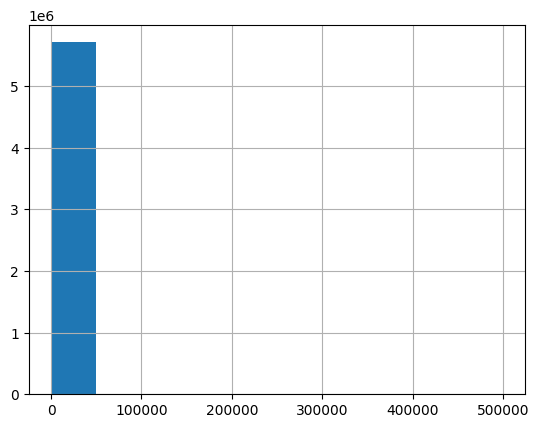

In [117]:
train_mol_per_scaffold = train_df.group_by('scaffold_idx').agg(
    pl.col('molecule').count()
).sort('molecule')
display(train_mol_per_scaffold)
train_mol_per_scaffold.to_pandas()['molecule'].hist()

In [124]:
train_mol_per_scaffold.describe(percentiles=PERCENTILES)

statistic,scaffold_idx,molecule
str,f64,f64
"""count""",5.711873e6,5.711873e6
"""null_count""",0.0,0.0
"""mean""",2.9859e6,17.230007
"""std""",1.7240e6,515.738802
"""min""",0.0,1.0
"""1%""",59632.0,1.0
"""2.5%""",149239.0,1.0
"""5%""",298466.0,1.0
"""10%""",597011.0,1.0


In [173]:
train_mol_per_scaffold.filter(pl.col('molecule') == 1).count()

scaffold_idx,molecule
u32,u32
2428120,2428120


In [174]:
2428120 / 5_711_873

0.4251004880535684

<Axes: >

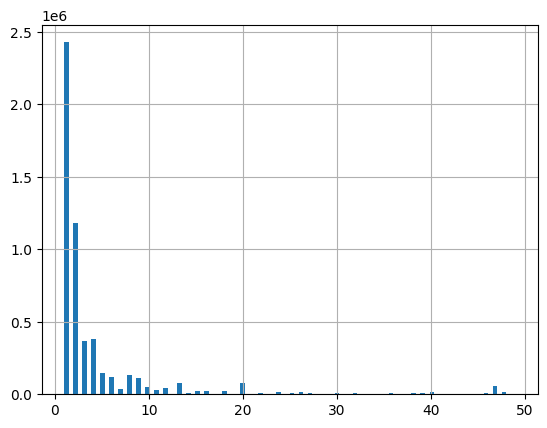

In [137]:
train_mol_per_scaffold.filter(pl.col('molecule') < 50).to_pandas()['molecule'].hist(bins = 100)

<Axes: >

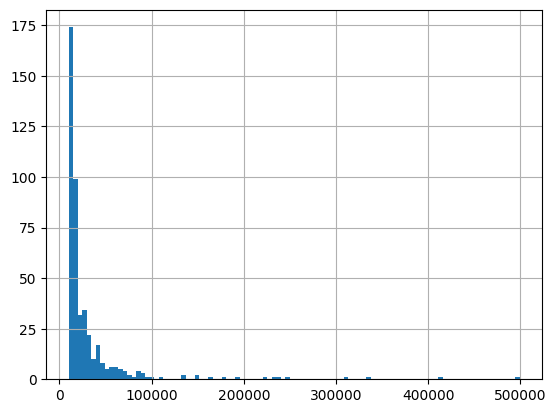

In [136]:
train_mol_per_scaffold.filter(pl.col('molecule') >= 10000).to_pandas()['molecule'].hist(bins = 100)

In [157]:
train_mol_per_scaffold.filter(pl.col('molecule') >= 10000).to_pandas()['molecule'].count()

450

In [158]:
train_mol_per_scaffold.filter(pl.col('molecule') >= 20000).to_pandas()['molecule'].count()

177

<Axes: >

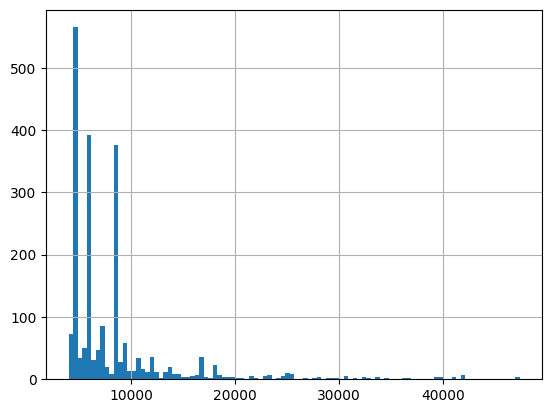

In [149]:
train_mol_per_scaffold.filter((pl.col('molecule') >= 4000) & (pl.col('molecule') <= 50000)).to_pandas()['molecule'].hist(bins = 100)

<Axes: >

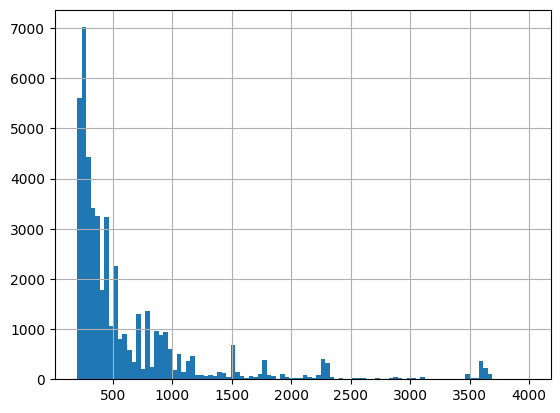

In [135]:
train_mol_per_scaffold.filter((pl.col('molecule') >= 200) & (pl.col('molecule') <= 4000)).to_pandas()['molecule'].hist(bins=100)

In [140]:
train_df2 = train_df.with_columns(
    pl.col('molecule').count().over('scaffold_idx').alias('mol_per_scaffold')
)
train_df2

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx,mol_per_scaffold
str,u16,u16,u16,u8,u8,u8,u32,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842


In [144]:
train_df2.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx,mol_per_scaffold
u32,u32,u32,u32,u32,u32,u32,u32,u32
98415610,271,693,872,2,2,2,5711873,3326


In [142]:
train_df2.filter(pl.col('mol_per_scaffold') >= 10000).select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx,mol_per_scaffold
u32,u32,u32,u32,u32,u32,u32,u32,u32
13908414,235,408,507,2,2,2,450,404


In [143]:
train_df2.filter(pl.col('mol_per_scaffold') >= 1000).select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx,mol_per_scaffold
u32,u32,u32,u32,u32,u32,u32,u32,u32
38029185,271,692,860,2,2,2,8897,2361


In [146]:
(8897 / 5711873) * 100

0.1557632671454705

In [147]:
38029185 / 98415610

0.38641415726631173

In [152]:
len(test1_df), len(test2_df), len(test3_df), len(test4_df)

(567779, 1107117, 516792, 590325)

In [168]:
1 / ((516792 * 3 / 2) / 98_415_610)

126.95708653900732

In [189]:
test2_df = test2_df.group_by('molecule').agg(pl.col('*').first())
test3_df = test3_df.group_by('molecule').agg(pl.col('*').first())
test4_df = test4_df.group_by('molecule').agg(pl.col('*').first())

scaffold_idx,molecule
u32,u32
5100845,1
1011938,1
5396299,1
2916660,1
1101596,1
757249,1
4234800,1
757642,1
2541772,1


<Axes: >

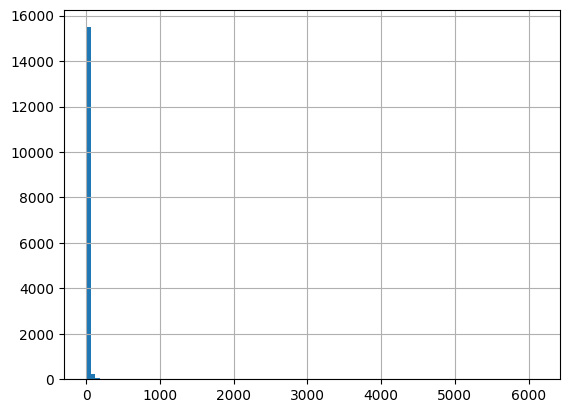

In [191]:
test3_mol_per_scaffold = test3_df.group_by('scaffold_idx').agg(
    pl.col('molecule').count()
).sort('molecule')
display(test3_mol_per_scaffold)
test3_mol_per_scaffold.to_pandas()['molecule'].hist(bins = 100)

In [192]:
test3_mol_per_scaffold.describe(percentiles=PERCENTILES)

statistic,scaffold_idx,molecule
str,f64,f64
"""count""",15908.0,15908.0
"""null_count""",0.0,0.0
"""mean""",2.9811e6,10.828765
"""std""",1.7168e6,105.882662
"""min""",791.0,1.0
"""1%""",63243.0,1.0
"""2.5%""",155421.0,1.0
"""5%""",301980.0,1.0
"""10%""",600890.0,1.0


In [194]:
test3_mol_per_scaffold.filter(pl.col('molecule') == 1).count()

scaffold_idx,molecule
u32,u32
9596,9596


In [195]:
9596 / 15_908

0.6032185064118682

<Axes: >

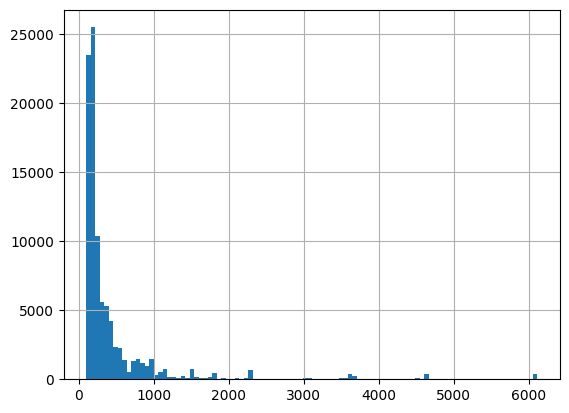

In [201]:
train_mol_per_scaffold.filter((pl.col('molecule') >= 100) & (pl.col('molecule') <= 6116)).to_pandas()['molecule'].hist(bins = 100)

<Axes: >

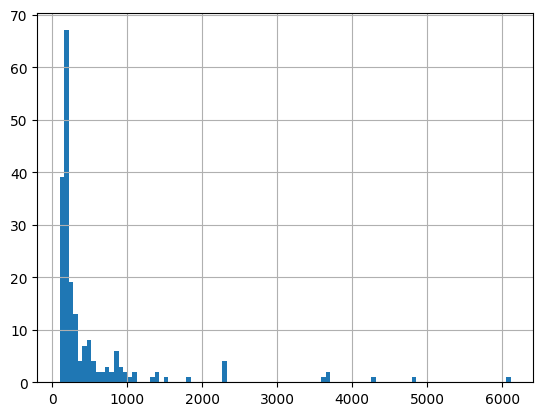

In [202]:
test3_mol_per_scaffold.filter((pl.col('molecule') >= 100) & (pl.col('molecule') <= 6116)).to_pandas()['molecule'].hist(bins=100)

In [196]:
train_mol_per_scaffold.filter(pl.col('molecule') >= 6116).count()

scaffold_idx,molecule
u32,u32
1119,1119


In [208]:
train_df2.shape

(98415610, 9)

In [209]:
train_df2.filter(pl.col('mol_per_scaffold') >= 6116).select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx,mol_per_scaffold
u32,u32,u32,u32,u32,u32,u32,u32,u32
19359604,247,684,858,2,2,2,1119,675


In [204]:
1119 / 5711873 * 100

0.01959077171358677

In [197]:
train_mol_per_scaffold.count()

scaffold_idx,molecule
u32,u32
5711873,5711873


In [206]:
train_df2.filter(pl.col('mol_per_scaffold') >= 7000).select(pl.col('BRD4', 'HSA', 'eSH').mean())

BRD4,HSA,eSH
f64,f64,f64
0.004478,0.002875,0.004319


In [162]:
train_mol_per_scaffold.shape

(5711873, 2)

In [160]:
train_mol_per_scaffold.filter(pl.col('molecule') >= 3).count()

scaffold_idx,molecule
u32,u32
2102137,2102137


In [163]:
train_mol_per_scaffold.filter(pl.col('molecule') < 3).count()

scaffold_idx,molecule
u32,u32
3609736,3609736


In [164]:
train_mol_per_scaffold.filter(pl.col('molecule') == 3).count()

scaffold_idx,molecule
u32,u32
367491,367491


scaffold_idx,molecule
u32,u32
4033854,1
1872871,1
2887560,1
4075670,1
4142388,1
1384337,1
2674687,1
365715,1
4146714,1


<Axes: >

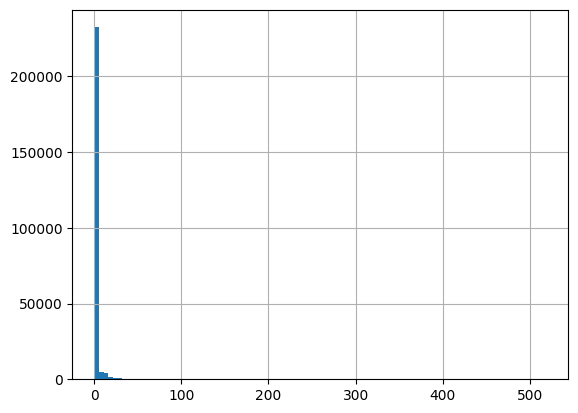

In [171]:
test1_mol_per_scaffold = test1_df.group_by('scaffold_idx').agg(
    pl.col('molecule').count()
).sort('molecule')
display(test1_mol_per_scaffold)
test1_mol_per_scaffold.to_pandas()['molecule'].hist(bins = 100)

In [172]:
test1_mol_per_scaffold.describe(percentiles=PERCENTILES)

statistic,scaffold_idx,molecule
str,f64,f64
"""count""",245841.0,245841.0
"""null_count""",0.0,0.0
"""mean""",2.9848e6,2.309537
"""std""",1.7222e6,7.037798
"""min""",1.0,1.0
"""1%""",61819.0,1.0
"""2.5%""",149932.0,1.0
"""5%""",300800.0,1.0
"""10%""",600517.0,1.0


In [175]:
test1_mol_per_scaffold.filter(pl.col('molecule') == 1).count()

scaffold_idx,molecule
u32,u32
182592,182592


In [176]:
182592 / (567779 + 1107117)

0.10901691806536047

In [210]:
test4_mol_per_scaffold = test4_df.group_by('scaffold_idx').agg(
    pl.col('molecule').count()
).sort('molecule')
display(test4_mol_per_scaffold)
test4_mol_per_scaffold.describe(percentiles=PERCENTILES)

scaffold_idx,molecule
u32,u32
3881932,1
998305,1
1656327,1
828951,1
2368878,1
2965029,1
4662252,1
3308197,1
496662,1


statistic,scaffold_idx,molecule
str,f64,f64
"""count""",107916.0,107916.0
"""null_count""",0.0,0.0
"""mean""",2.9843e6,1.823409
"""std""",1.7268e6,7.78643
"""min""",12.0,1.0
"""1%""",59190.0,1.0
"""2.5%""",147043.0,1.0
"""5%""",296375.0,1.0
"""10%""",591440.0,1.0


In [180]:
test2_mol_per_scaffold = test2_df.group_by('scaffold_idx').agg(
    pl.col('molecule').count()
).sort('molecule')
display(test2_mol_per_scaffold)
test2_mol_per_scaffold.describe(percentiles=PERCENTILES)

scaffold_idx,molecule
u32,u32
820299,3
3954682,3
1465212,3
4526321,3
1498114,3
3276736,3
4219071,3
4741031,3
333337,3


statistic,scaffold_idx,molecule
str,f64,f64
"""count""",123824.0,123824.0
"""null_count""",0.0,0.0
"""mean""",2.9839e6,8.941053
"""std""",1.7255e6,116.27334
"""min""",12.0,3.0
"""1%""",59703.0,3.0
"""2.5%""",147857.0,3.0
"""5%""",297408.0,3.0
"""10%""",592753.0,3.0


In [181]:
107916 + 15908

123824

In [185]:
# after_bb_train_df = pl.concat([train_df, test2_df.with_columns(binds=pl.lit(2))], how = 'align')
# after_bb_train_df

In [190]:
test2_df.select(pl.col('*').n_unique())

molecule,id,bb1,bb2,bb3,protein,scaffold_idx
u32,u32,u32,u32,u32,u32,u32
369039,369039,271,693,871,1,123824


In [103]:
196775 / 107916

1.823408947700063

In [104]:
98_415_610 / 5_711_873

17.230006689574505

In [109]:
15908 / 5711873

0.002785075928683989

Hmm.., seem like test2 is not constructed from a scaffold split, since test2_only_scaffold is just 15908 << 107916, and is 0.2785% of train scaffolds

In [91]:
122831 / 5711873

0.021504504739513642

In [93]:
1107117 / 98_415_610

0.011249404438990928

In [ ]:
123824 / 

In [85]:
123824 + 245841 - 368_671

994

In [86]:
123824 / 245841

0.5036751396227643